<a href="https://colab.research.google.com/github/Ramsha-amir26/ThoraricDiseaseDetectionUsingFewShotLearning/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/fewshotscripts/')

import prototypical_network
import train_and_evaluation

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4
from torchvision import models
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

import pandas as pd
from sklearn.metrics import classification_report

import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
class CFG:
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,3)


augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-.01, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED)
], name='augmentation_layer')

def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, clahe_image, augmented_image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(clahe_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')

    axes[2].imshow(augmented_image)
    axes[2].set_title("Image after Augmentation")
    axes[2].axis('off')

    plt.show()

def read_xray_images(directory_path, img_height, img_width, selected_classes=None, augmentation=True,
                     normalize=False, apply_clahe_flag=True, display_comparison=False):
    datax = []
    datay = []

    sub_directories = os.listdir(directory_path)

    if selected_classes is None:
        selected_classes = sub_directories
    else:
        for cls in selected_classes:
            if cls not in sub_directories:
                raise ValueError(f"Class '{cls}' not found in {directory_path}. Available classes: {sub_directories}")

    for sub_dir in selected_classes:
        sub_dir_path = os.path.join(directory_path, sub_dir)
        correct_image_filepaths = check_image_path(sub_dir_path)

        for fpath in correct_image_filepaths:
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))

            original_image = image.copy()

            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
                image = enhanced_image

            if augmentation:
                image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
                augmented_image = augmentation_layer(image_tensor)  # Apply augmentation layer
                augmented_image = augmented_image.numpy().astype(np.uint8)  # Convert back to numpy array

            if normalize:
                image = image / 255.0

            if display_comparison:
                display_image_comparison(original_image, enhanced_image, augmented_image)

            datax.append(image)
            datay.append(sub_dir)

    return np.array(datax), np.array(datay)

In [6]:
resnet50_model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [7]:
resnet50_model = resnet50_model.to(device)
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [9]:
for param in resnet50_model.parameters():
  param.requires_grad = False

In [10]:
resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [11]:
import zipfile
zip_file_path = r"/content/drive/MyDrive/Datasets/FewShotGroups.zip"
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group1"

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("/content/drive/MyDrive/Datasets/")
    print(f"Extracted FewShotGroups to {test_data_dir}")
else:
    print(f"{zip_file_path} not found!")

Extracted FewShotGroups to /content/drive/MyDrive/Datasets/FewShotGroups/Group1


In [12]:
def generate_classification_report(results, sample_images):
    y_true_flat = results["y_true"].flatten()
    y_pred_flat = results["y_pred"].flatten()


    class_labels = sample_images["class_labels"]
    label_mapping = {i: label for i, label in enumerate(class_labels)}


    report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
    return report

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(results):
    """
    Generates and plots the Receiver Operating Characteristic (ROC) curve.
    """

    y_true_flat = results["y_true"].flatten()
    y_scores = results["y_pred"].flatten()

    fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [14]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)

    cmap = plt.cm.Blues
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)


    disp.plot(cmap=cmap, values_format='d')


    plt.title("Confusion Matrix", fontsize=12, pad=20)
    plt.grid(False)
    plt.colorbar(disp.im_, fraction=0.046, pad=0.04)


    plt.tight_layout()
    plt.show()

In [15]:
import pandas as pd
import os

def test_model_on_one_task(model, n_way, n_support, n_query, test_episodes, x_test, y_test, output_dir, file_name):
    """
    Tests the Prototypical Network on a test set and saves every 100th episode result to a CSV file.

    Args:
        model: trained model
        n_way (int): number of classes in a classification task
        n_support (int): number of images per class in the support set
        n_query (int): number of images per class in the query set
        test_episodes (int): number of episodes to test on
        x_test (np.array): images of testing set
        y_test (np.array): labels of testing set
        output_dir (str): Directory to save the CSV file
        file_name (str): The name of the CSV file to save results

    Returns:
        avg_loss (float): average loss
        avg_acc (float): average accuracy
    """

    running_loss = 0.0
    running_acc = 0.0


    results = []
    model.eval()

    print(f"Saving loss and accuracy every 100 episodes: ")
    with torch.no_grad():
        for episode in range(test_episodes):
            sample = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']


            if episode % 100 == 0:
                print(f"Episode: {episode} ---> Loss: {output['loss']:.3f}, Accuracy: {output['acc']:.2f}")

                results.append({
                    'Episode': episode,
                    'Loss': output['loss'],
                    'Accuracy': output['acc']
                })

        avg_loss = running_loss / test_episodes
        avg_acc = running_acc / test_episodes


    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    csv_path = os.path.join(output_dir, file_name)
    df = pd.DataFrame(results)
    df.to_csv(csv_path, index=False)

    return avg_loss, avg_acc

## **GROUP 1**

In [16]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group1"
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

In [17]:
x_test.shape, y_test.shape

((60, 224, 224, 3), (60,))

Class labels sampled: ['Covid19' 'Effusion']


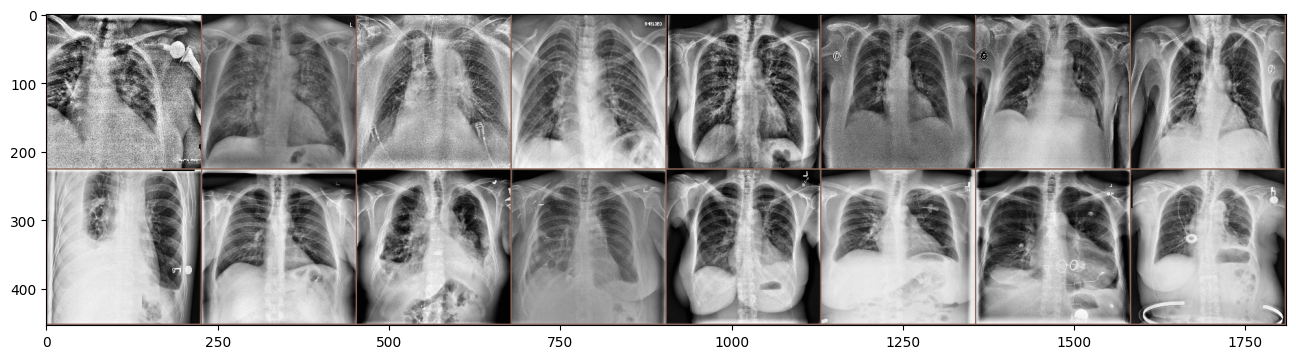

In [18]:
n_way = 2
n_support = 5
n_query = 3
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

In [19]:
import csv
output_dir = '/content/drive/MyDrive/Colab_Results/RESNET50'

os.makedirs(output_dir, exist_ok=True)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 1

In [20]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'resnet50_2_way_3shot_testing_group1.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 4.863, Accuracy: 0.75
Episode: 100 ---> Loss: 1.845, Accuracy: 0.90
Episode: 200 ---> Loss: 2.631, Accuracy: 0.90
Episode: 300 ---> Loss: 4.651, Accuracy: 0.85
Episode: 400 ---> Loss: 8.783, Accuracy: 0.60
Episode: 500 ---> Loss: 17.003, Accuracy: 0.65
Episode: 600 ---> Loss: 6.276, Accuracy: 0.80
Episode: 700 ---> Loss: 11.157, Accuracy: 0.70
Episode: 800 ---> Loss: 8.077, Accuracy: 0.55
Episode: 900 ---> Loss: 2.505, Accuracy: 0.70
Episode: 1000 ---> Loss: 19.330, Accuracy: 0.70
Episode: 1100 ---> Loss: 12.296, Accuracy: 0.60
Episode: 1200 ---> Loss: 4.855, Accuracy: 0.65
Episode: 1300 ---> Loss: 8.546, Accuracy: 0.80
Episode: 1400 ---> Loss: 9.533, Accuracy: 0.75
Episode: 1500 ---> Loss: 9.783, Accuracy: 0.45
Episode: 1600 ---> Loss: 14.887, Accuracy: 0.60
Episode: 1700 ---> Loss: 13.590, Accuracy: 0.65
Episode: 1800 ---> Loss: 3.825, Accuracy: 0.90
Episode: 1900 ---> Loss: 4.288, Accuracy: 0.80
Episode: 2000 ---> L

### Prototypical Network Prediction with resNet50 2 Way 3 Shot

Class labels sampled: ['Effusion' 'Covid19']
{'loss': 1.0303239822387695, 'acc': 0.8500000238418579, 'y_hat': tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 1]])}


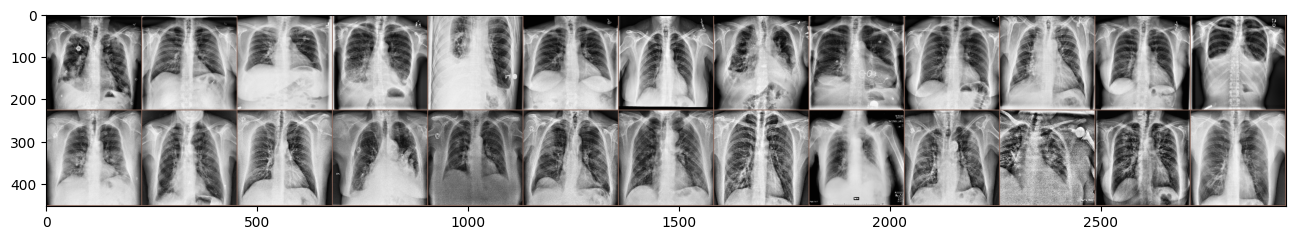

In [21]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [22]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2_way_3shot_results_group1.csv"), index=False)
print("Results saved to prototypical_model_results_resnet_2way_3shot_group1.csv")

Results saved to prototypical_model_results_resnet_2way_3shot_group1.csv


### Classification Report

In [23]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

    Effusion       0.82      0.90      0.86        10
     Covid19       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



### ROC Curve

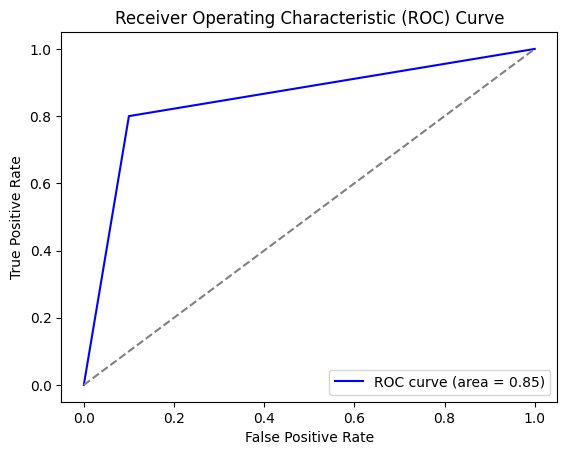

In [24]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

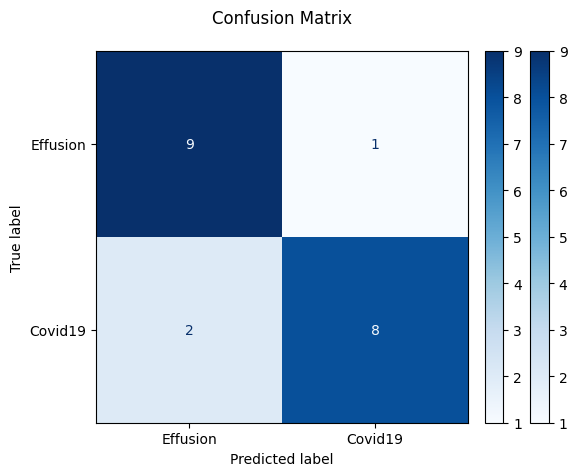

In [25]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 1

In [26]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'resnet50_2_way_5shot_testing_group1.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 1.070, Accuracy: 0.87
Episode: 100 ---> Loss: 3.600, Accuracy: 0.87
Episode: 200 ---> Loss: 4.430, Accuracy: 0.80
Episode: 300 ---> Loss: 2.475, Accuracy: 0.80
Episode: 400 ---> Loss: 4.132, Accuracy: 0.77
Episode: 500 ---> Loss: 6.291, Accuracy: 0.73
Episode: 600 ---> Loss: 4.356, Accuracy: 0.77
Episode: 700 ---> Loss: 2.827, Accuracy: 0.83
Episode: 800 ---> Loss: 5.436, Accuracy: 0.73
Episode: 900 ---> Loss: 3.501, Accuracy: 0.77
Episode: 1000 ---> Loss: 2.979, Accuracy: 0.80
Episode: 1100 ---> Loss: 5.237, Accuracy: 0.77
Episode: 1200 ---> Loss: 4.367, Accuracy: 0.80
Episode: 1300 ---> Loss: 0.755, Accuracy: 0.83
Episode: 1400 ---> Loss: 2.434, Accuracy: 0.80
Episode: 1500 ---> Loss: 4.139, Accuracy: 0.83
Episode: 1600 ---> Loss: 1.890, Accuracy: 0.87
Episode: 1700 ---> Loss: 2.522, Accuracy: 0.73
Episode: 1800 ---> Loss: 2.217, Accuracy: 0.83
Episode: 1900 ---> Loss: 6.634, Accuracy: 0.77
Episode: 2000 ---> Loss: 4

### Prototypical Network Prediction with resNet50 2 Way 5 Shot Group 1

Class labels sampled: ['Covid19' 'Effusion']
{'loss': 1.608158826828003, 'acc': 0.8666667342185974, 'y_hat': tensor([[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


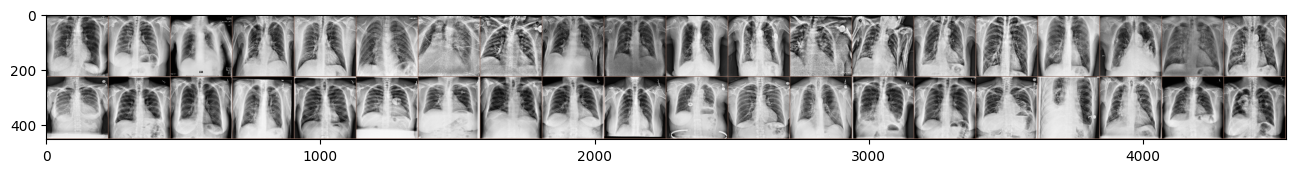

In [31]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [32]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2way_5shot_results_group1.csv"), index=False)
print("Results saved to resnet50_2way_5shot_group1.csv")

Results saved to resnet50_2way_5shot_group1.csv


### Classification Report

In [33]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

     Covid19       1.00      0.73      0.85        15
    Effusion       0.79      1.00      0.88        15

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.86        30
weighted avg       0.89      0.87      0.86        30



### ROC curve

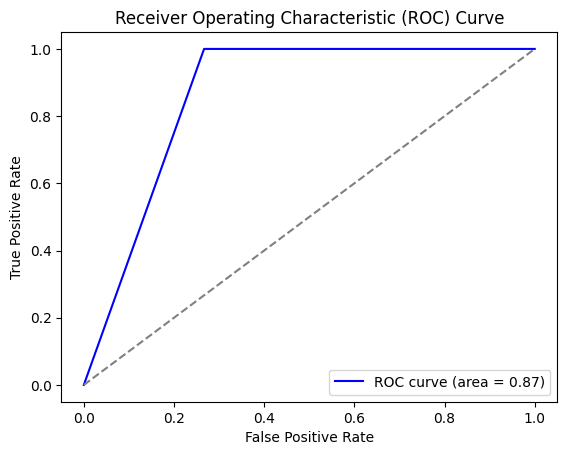

In [34]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

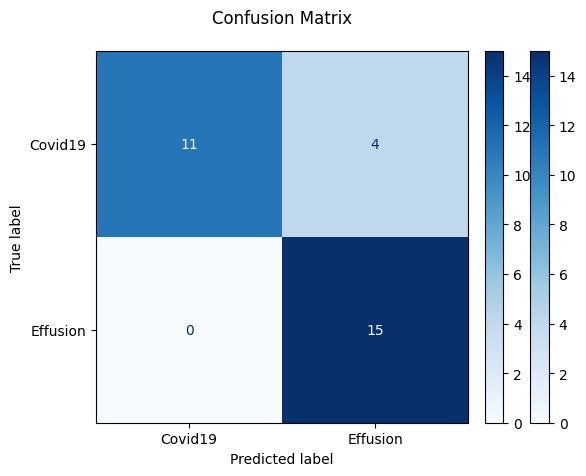

In [35]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

## **GROUP 2**

In [36]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group2"
data_dir = test_data_dir
selected_classes = ['Pneumonia', 'Cardiomegaly']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 2

In [37]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'resnet50_2_way_3shot_testing_group2.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 17.278, Accuracy: 0.40
Episode: 100 ---> Loss: 13.002, Accuracy: 0.70
Episode: 200 ---> Loss: 41.387, Accuracy: 0.55
Episode: 300 ---> Loss: 12.024, Accuracy: 0.55
Episode: 400 ---> Loss: 11.695, Accuracy: 0.60
Episode: 500 ---> Loss: 3.286, Accuracy: 0.75
Episode: 600 ---> Loss: 17.564, Accuracy: 0.45
Episode: 700 ---> Loss: 158.515, Accuracy: 0.50
Episode: 800 ---> Loss: 11.530, Accuracy: 0.50
Episode: 900 ---> Loss: 10.000, Accuracy: 0.60
Episode: 1000 ---> Loss: 48.046, Accuracy: 0.65
Episode: 1100 ---> Loss: 11.467, Accuracy: 0.50
Episode: 1200 ---> Loss: 35.836, Accuracy: 0.50
Episode: 1300 ---> Loss: 16.496, Accuracy: 0.55
Episode: 1400 ---> Loss: 8.364, Accuracy: 0.70
Episode: 1500 ---> Loss: 10.737, Accuracy: 0.60
Episode: 1600 ---> Loss: 5.777, Accuracy: 0.50
Episode: 1700 ---> Loss: 30.879, Accuracy: 0.50
Episode: 1800 ---> Loss: 7.818, Accuracy: 0.65
Episode: 1900 ---> Loss: 22.231, Accuracy: 0.55
Episode: 

### Prototypical Network Prediction with resNet50 2 Way 3 Shot Group 2

Class labels sampled: ['Cardiomegaly' 'Pneumonia']
{'loss': 12.478288650512695, 'acc': 0.6500000357627869, 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 1, 0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 1, 0]])}


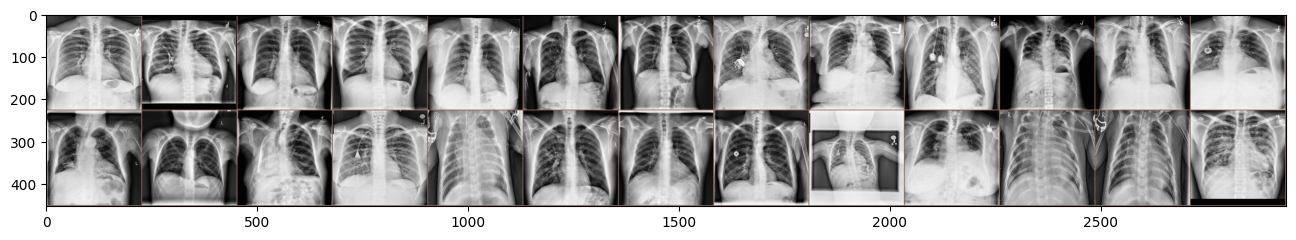

In [38]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [39]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2_way_3shot_results_group2.csv"), index=False)
print("Results saved to prototypical_model_results_resnet_2way_3shot_group2.csv")

Results saved to prototypical_model_results_resnet_2way_3shot_group2.csv


### Classification Report

In [40]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

Cardiomegaly       0.60      0.90      0.72        10
   Pneumonia       0.80      0.40      0.53        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20



### ROC Curve

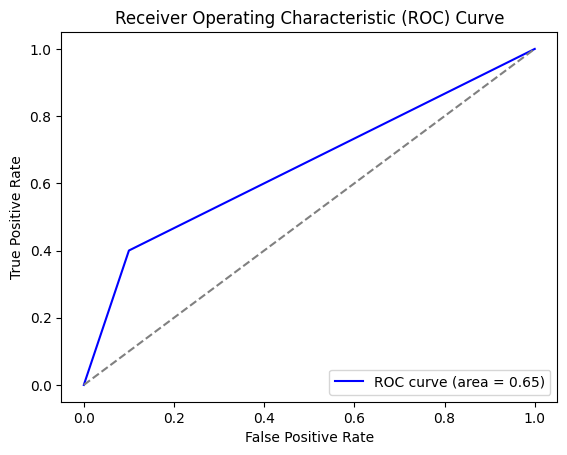

In [41]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

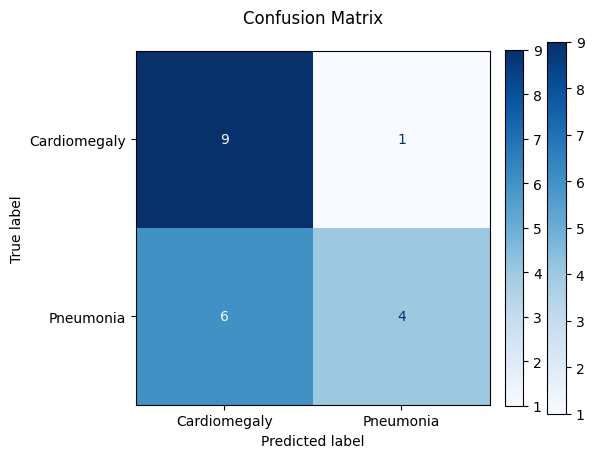

In [42]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 2

In [43]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'resnet50_2_way_5shot_testing_group2.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 30.688, Accuracy: 0.57
Episode: 100 ---> Loss: 12.611, Accuracy: 0.57
Episode: 200 ---> Loss: 7.789, Accuracy: 0.67
Episode: 300 ---> Loss: 13.936, Accuracy: 0.73
Episode: 400 ---> Loss: 9.945, Accuracy: 0.73
Episode: 500 ---> Loss: 20.861, Accuracy: 0.63
Episode: 600 ---> Loss: 25.552, Accuracy: 0.30
Episode: 700 ---> Loss: 11.008, Accuracy: 0.60
Episode: 800 ---> Loss: 15.899, Accuracy: 0.43
Episode: 900 ---> Loss: 20.854, Accuracy: 0.73
Episode: 1000 ---> Loss: 11.952, Accuracy: 0.50
Episode: 1100 ---> Loss: 7.524, Accuracy: 0.60
Episode: 1200 ---> Loss: 23.242, Accuracy: 0.60
Episode: 1300 ---> Loss: 34.518, Accuracy: 0.57
Episode: 1400 ---> Loss: 11.418, Accuracy: 0.47
Episode: 1500 ---> Loss: 15.866, Accuracy: 0.33
Episode: 1600 ---> Loss: 8.838, Accuracy: 0.47
Episode: 1700 ---> Loss: 19.504, Accuracy: 0.60
Episode: 1800 ---> Loss: 7.890, Accuracy: 0.57
Episode: 1900 ---> Loss: 4.937, Accuracy: 0.63
Episode: 200

### Prototypical Network Prediction with resnet50 2 Way 5 Shot Group 2

Class labels sampled: ['Pneumonia' 'Cardiomegaly']
{'loss': 8.408950805664062, 'acc': 0.7000000476837158, 'y_hat': tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]])}


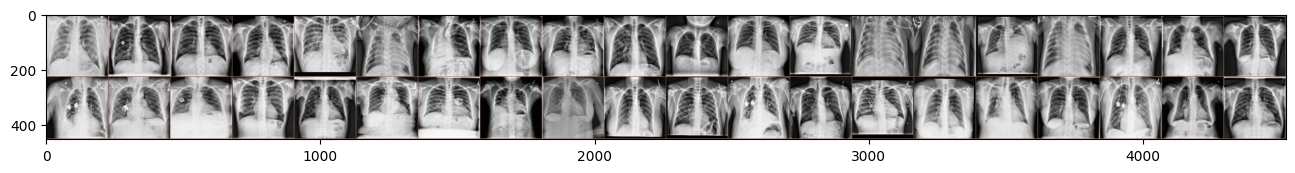

In [54]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [55]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2_way_5shot_results_group2.csv"), index=False)
print("Results saved to resnet50_2_way_5shot_results_group2.csv")

Results saved to resnet50_2_way_5shot_results_group2.csv


### Classification Report

In [56]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

   Pneumonia       0.69      0.73      0.71        15
Cardiomegaly       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



### ROC Curve

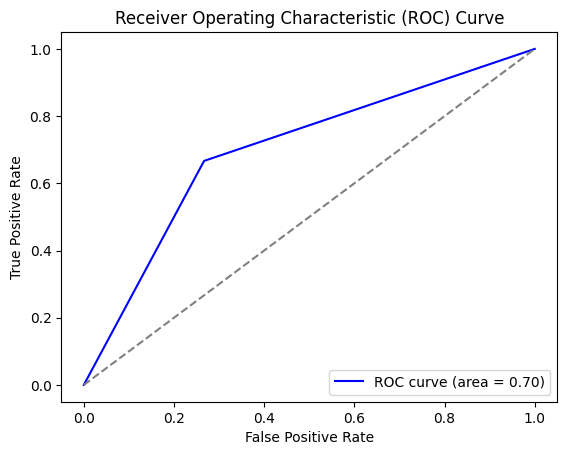

In [57]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

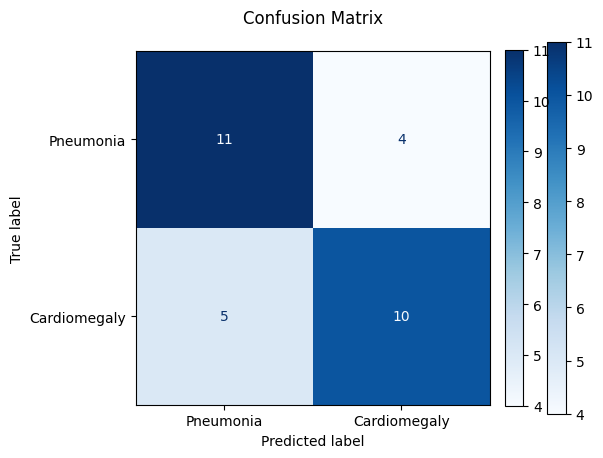

In [58]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

## **GROUP 3**

In [60]:
img_height, img_width = 224, 224
test_data_dir = r"/content/drive/MyDrive/Datasets/FewShotGroups/Group3"
data_dir = test_data_dir
selected_classes = ['Atelectasis', 'Fibrosis']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=True
)

### Prototypical Network Evaluation in Episodic Learning 2 Way 3 Shot Group 3

In [61]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10
file_name = 'resnet50_2_way_3shot_testing_group3.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 6.363, Accuracy: 0.50
Episode: 100 ---> Loss: 11.739, Accuracy: 0.50
Episode: 200 ---> Loss: 7.407, Accuracy: 0.60
Episode: 300 ---> Loss: 12.695, Accuracy: 0.50
Episode: 400 ---> Loss: 6.099, Accuracy: 0.55
Episode: 500 ---> Loss: 11.262, Accuracy: 0.45
Episode: 600 ---> Loss: 10.131, Accuracy: 0.50
Episode: 700 ---> Loss: 11.922, Accuracy: 0.40
Episode: 800 ---> Loss: 20.504, Accuracy: 0.35
Episode: 900 ---> Loss: 5.440, Accuracy: 0.60
Episode: 1000 ---> Loss: 10.125, Accuracy: 0.45
Episode: 1100 ---> Loss: 6.056, Accuracy: 0.50
Episode: 1200 ---> Loss: 10.676, Accuracy: 0.30
Episode: 1300 ---> Loss: 8.851, Accuracy: 0.50
Episode: 1400 ---> Loss: 14.629, Accuracy: 0.50
Episode: 1500 ---> Loss: 22.263, Accuracy: 0.45
Episode: 1600 ---> Loss: 7.963, Accuracy: 0.40
Episode: 1700 ---> Loss: 3.958, Accuracy: 0.60
Episode: 1800 ---> Loss: 11.491, Accuracy: 0.55
Episode: 1900 ---> Loss: 5.030, Accuracy: 0.60
Episode: 2000 -

### Prototypical Network Prediction with resnet50 2 Way 3 Shot Group 3

Class labels sampled: ['Atelectasis' 'Fibrosis']
{'loss': 6.4722771644592285, 'acc': 0.550000011920929, 'y_hat': tensor([[0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 1]])}


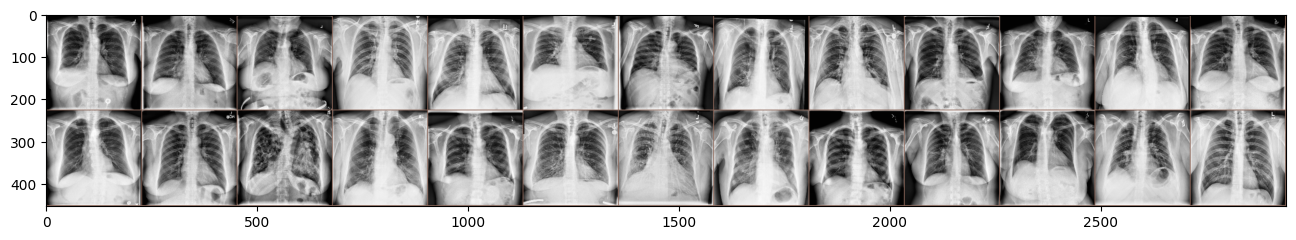

In [67]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 10

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [68]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2_way_3shot_results_group3.csv"), index=False)
print("Results saved to resnet50_2_way_3shot_results_group3.csv")

Results saved to resnet50_2_way_3shot_results_group3.csv


### Classification Report

In [69]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

 Atelectasis       0.54      0.70      0.61        10
    Fibrosis       0.57      0.40      0.47        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
weighted avg       0.55      0.55      0.54        20



### ROC Curve

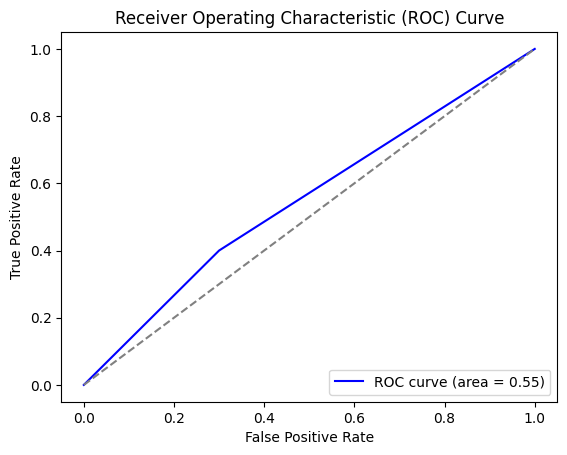

In [70]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

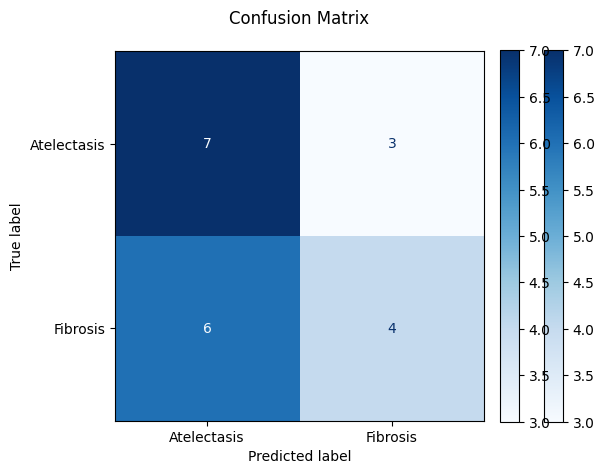

In [71]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)

### Prototypical Network Evaluation in Episodic Learning 2 Way 5 Shot Group 2

In [72]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15
file_name = 'resnet50_2_way_5shot_testing_group3.csv'

test_episodes = 5000

test_loss, test_accuracy = test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test=x_test, y_test=y_test, output_dir=output_dir, file_name=file_name)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Saving loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 7.693, Accuracy: 0.43
Episode: 100 ---> Loss: 6.321, Accuracy: 0.57
Episode: 200 ---> Loss: 7.616, Accuracy: 0.63
Episode: 300 ---> Loss: 8.762, Accuracy: 0.40
Episode: 400 ---> Loss: 6.997, Accuracy: 0.57
Episode: 500 ---> Loss: 10.642, Accuracy: 0.33
Episode: 600 ---> Loss: 5.473, Accuracy: 0.50
Episode: 700 ---> Loss: 6.294, Accuracy: 0.63
Episode: 800 ---> Loss: 9.481, Accuracy: 0.47
Episode: 900 ---> Loss: 11.981, Accuracy: 0.33
Episode: 1000 ---> Loss: 10.793, Accuracy: 0.57
Episode: 1100 ---> Loss: 5.058, Accuracy: 0.47
Episode: 1200 ---> Loss: 4.901, Accuracy: 0.50
Episode: 1300 ---> Loss: 10.105, Accuracy: 0.43
Episode: 1400 ---> Loss: 8.806, Accuracy: 0.40
Episode: 1500 ---> Loss: 7.126, Accuracy: 0.40
Episode: 1600 ---> Loss: 13.774, Accuracy: 0.47
Episode: 1700 ---> Loss: 11.109, Accuracy: 0.50
Episode: 1800 ---> Loss: 5.494, Accuracy: 0.50
Episode: 1900 ---> Loss: 9.148, Accuracy: 0.43
Episode: 2000 ---> L

### Prototypical Network Prediction with resnet50 2 Way 5 Shot Group 3

Class labels sampled: ['Fibrosis' 'Atelectasis']
{'loss': 7.404712200164795, 'acc': 0.5333333611488342, 'y_hat': tensor([[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]])}


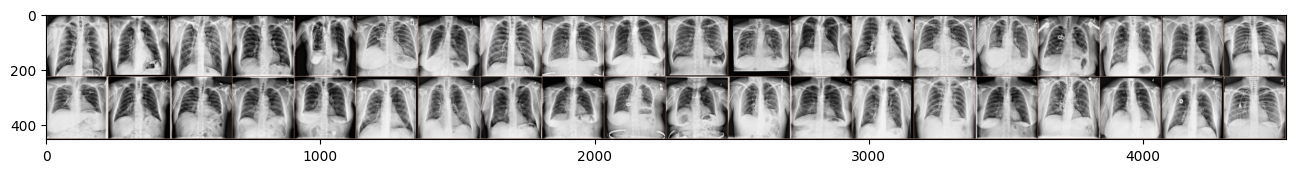

In [74]:
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 15

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [75]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data).to_csv(os.path.join(output_dir, "resnet50_2_way_5shot_results_group3.csv"), index=False)
print("Results saved to resnet50_2_way_5shot_results_group3.csv")

Results saved to resnet50_2_way_5shot_results_group3.csv


### Classification Report

In [76]:
report = generate_classification_report(results, sample_images)
print(report)

              precision    recall  f1-score   support

    Fibrosis       0.55      0.40      0.46        15
 Atelectasis       0.53      0.67      0.59        15

    accuracy                           0.53        30
   macro avg       0.54      0.53      0.52        30
weighted avg       0.54      0.53      0.52        30



### ROC Curve

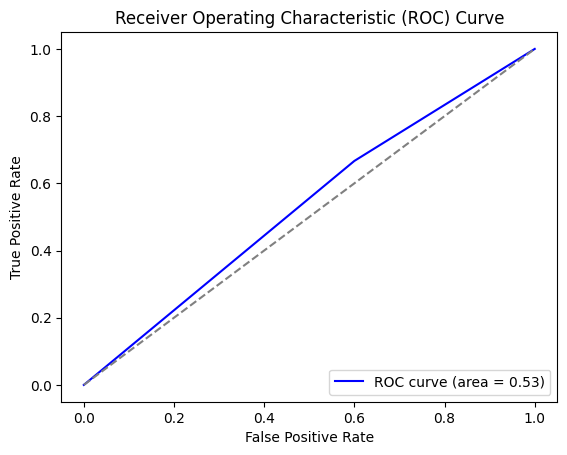

In [77]:
plot_roc_curve(results)

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

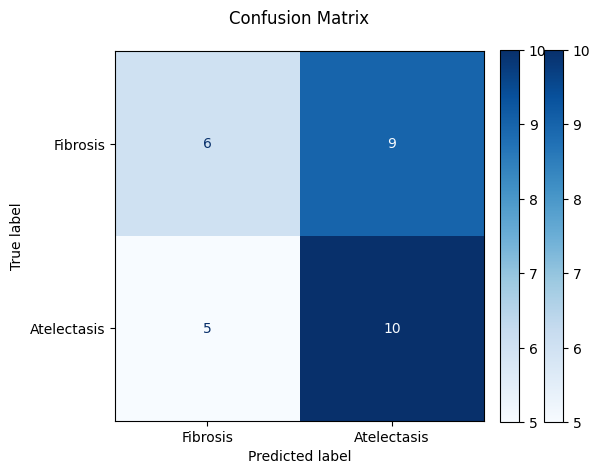

In [78]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()
class_labels = sample_images["class_labels"]
plot_confusion_matrix(y_true_flat, y_pred_flat, class_labels)